## Product Selection

In [1]:
# sheet='C1'
# sheet='C2'
# sheet='BYX'
# sheet='BZX'
# sheet='EDGA'
# sheet='EDGX_Equities'
sheet='EXO_EDGX_Options'
# sheet='OPT_BZX_BATS'
# sheet='CFE'

## 1m

In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


import io
import datetime

# sheet='C1'
# sheet='C2'
# sheet='BYX'
# sheet='BZX'
# sheet='EDGA'
# sheet='EDGX_Equities'
# sheet='EXO_EDGX Options'
# sheet='OPT_BZX BATS'
# sheet='CFE'

#load ensemble
import os
from keras.models import load_model

df= pd.read_excel(r'../Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))
# # df=df.drop(['D&J_Close30d_Avg.','D&J_Close30d_Min','Monthly Real GDP Index','TCV','FEDFUNDS','Unemployement Rate','SPX_Price30d_Std.','D&J_Close30d_Std.','VIX_Close30d_Max.','VIX_Close30d_Avg.','VIX_Close30d_Std.','VIX_Close30d_Min.'],axis=1)

values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # encoder = LabelEncoder()
# # # # print(values[:,0]) #PortQyt Value
# # values[:,0]=encoder.fit_transform(values[:,0])
# # print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
# print(reframed.shape)


# print(reframed.tail())

# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = ((n_months+1))* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+5):-n_features*(1+5)+1]
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+5):-n_features*(1+5)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1) , n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# prediction interval for mlps on the housing regression dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np


# define and fit the model
def fit_model(X_train, y_train):
    features = X_train.shape[1]
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, verbose=0, epochs=50, batch_size=16)
    return model



# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        model = fit_model(X_train, y_train) # define and fit the model on the training set
        yhat = model.predict(X_test, verbose=0) # evaluate model on the test set
        print(y_test.shape,yhat.shape)
        mae = mean_absolute_error(y_test, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        ensemble.append(model) # store the model
    return ensemble, model

n_members = 20
ensemble = list()
for i in range(n_members):
  model = fit_model(train_X, train_y) # define and fit the model on the training set
  yhat = model.predict(test_X, verbose=0) # evaluate model on the test set
  print(test_y,yhat.shape)
  mae = mean_absolute_error(test_y, yhat)
  print('>%d, MAE: %.3f' % (i+1, mae))
  ensemble.append(model) # store the model

# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X,n_members):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    yhat = np.reshape(yhat,[n_members,1])
    print(yhat.shape)
    # yhat = scaled2.inverse_transform(yhat)
    yhat = scaler2.inverse_transform(yhat) # invert scaling for actual
    yhat = yhat[:,0]
    interval = 1.96 * yhat.std()/math.sqrt(len(yhat))
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome1= pd.DataFrame(outcome)
outcome1



18
(37, 108)
(1, 108)
(36, 6, 18) (36, 1) (1, 6, 18) (1, 1)
Metal device set to: Apple M1


2022-09-07 00:00:51.628145: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-07 00:00:51.628295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-09-07 00:00:52.073044: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-07 00:00:53.183065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:00:53.458185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:00:55.592695: I tensorflow/core/grappler/o

[[0.775463]] (1, 1)
>1, MAE: 0.079


2022-09-07 00:01:00.425569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:00.692575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:00.797763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:02.693918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:02.780923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>2, MAE: 0.056


2022-09-07 00:01:04.032562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:04.299088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:04.391925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:07.951920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:08.215586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>3, MAE: 0.011


2022-09-07 00:01:10.513361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:10.775480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:10.871853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:12.856805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:12.944158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>4, MAE: 0.060


2022-09-07 00:01:14.273200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:14.537723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:14.634892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-09-07 00:01:16.634930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:16.723764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>5, MAE: 0.054


2022-09-07 00:01:18.201052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:18.464489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:18.564322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-09-07 00:01:20.701339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:20.788091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>6, MAE: 0.059


2022-09-07 00:01:22.132117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:22.402276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:22.503741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:24.510000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:24.600467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>7, MAE: 0.071


2022-09-07 00:01:26.111842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:26.377735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:26.474885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:28.540027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:28.628490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>8, MAE: 0.066


2022-09-07 00:01:30.143456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:30.413782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:30.516915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:32.671937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:32.761953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>9, MAE: 0.056


2022-09-07 00:01:34.051111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:34.324953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:34.439543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:36.478993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:36.566441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>10, MAE: 0.059


2022-09-07 00:01:38.070052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:38.334746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:38.441277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:40.420118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:40.509012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>11, MAE: 0.034


2022-09-07 00:01:41.777510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:42.041889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:42.151703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:44.113183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:44.201060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>12, MAE: 0.054


2022-09-07 00:01:45.471410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:45.734606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:45.842090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:47.815762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:47.903907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>13, MAE: 0.093


2022-09-07 00:01:49.418088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:49.682920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:49.791745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:51.771516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:51.868380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>14, MAE: 0.066


2022-09-07 00:01:53.161174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:53.430605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:53.536261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:55.527420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:55.615469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>15, MAE: 0.069


2022-09-07 00:01:56.899381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:57.162240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:57.298185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:59.327049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:01:59.414700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>16, MAE: 0.064


2022-09-07 00:02:00.705844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:00.968872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:01.107195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:03.164641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:03.252561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>17, MAE: 0.044


2022-09-07 00:02:04.836422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:05.101882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:05.220881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:07.287070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:07.374314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>18, MAE: 0.061


2022-09-07 00:02:08.660808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:08.934584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:09.073547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:11.150355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:11.238215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>19, MAE: 0.064


2022-09-07 00:02:12.515738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:12.781256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:12.915564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:15.011064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:15.098445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.775463]] (1, 1)
>20, MAE: 0.026
(20, 1)
95% prediction interval: [653.5, 660.1]
True value: 0.8


,Prediction,95%CI.Min,95%CI.Max
0,656.793579,653.470549,660.116609


In [3]:
from os import path
#save ensemble
for i,i_model in enumerate(ensemble):
    i_model.save(path.join(sheet, '1',f'ensemble_corr_{i}.h5'))
#   i_model.save(f'BYX/1/ensemble_corr_{i}.h5')



#save model
# model.save(f'/1/model_corr.h5')
model.save(path.join(sheet, '1','model_corr.h5'))

## 2m

In [4]:
from math import sqrt
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import io
import datetime

# sheet='BYX'
df= pd.read_excel(r'../Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))
# # df=df.drop(['D&J_Close30d_Avg.','D&J_Close30d_Min','Monthly Real GDP Index','TCV','FEDFUNDS','Unemployement Rate','SPX_Price30d_Std.','D&J_Close30d_Std.','VIX_Close30d_Max.','VIX_Close30d_Avg.','VIX_Close30d_Std.','VIX_Close30d_Min.'],axis=1)


values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
# print(reframed.shape)


# print(reframed.tail())


# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = ((n_months+1))* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+4):-n_features*(1+4)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+4):-n_features*(1+4)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1) , n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# prediction interval for mlps on the housing regression dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np

 
# define and fit the model
def fit_model(X_train, y_train):
    features = X_train.shape[1]
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, verbose=0, epochs=50, batch_size=16)
    return model

	
 
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        model = fit_model(X_train, y_train) # define and fit the model on the training set
        yhat = model.predict(X_test, verbose=0) # evaluate model on the test set
        print(y_test.shape,yhat.shape)
        mae = mean_absolute_error(y_test, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        ensemble.append(model) # store the model
    return ensemble

n_members = 20
ensemble = list()
for i in range(n_members):
  model = fit_model(train_X, train_y) # define and fit the model on the training set
  yhat = model.predict(test_X, verbose=0) # evaluate model on the test set
  print(test_y,yhat.shape)
  mae = mean_absolute_error(test_y, yhat)
  print('>%d, MAE: %.3f' % (i+1, mae))
  ensemble.append(model) # store the model
    
# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X,n_members):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    yhat = np.reshape(yhat,[n_members,1])
    print(yhat.shape)
    # yhat = scaled2.inverse_transform(yhat)
    yhat = scaler2.inverse_transform(yhat) # invert scaling for actual
    yhat = yhat[:,0] 
    interval = 1.96 * yhat.std()/math.sqrt(len(yhat))
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome2= pd.DataFrame(outcome)
outcome2

from os import path
#save ensemble
for i,i_model in enumerate(ensemble):
    i_model.save(path.join(sheet, '2',f'ensemble_corr_{i}.h5'))
#   i_model.save(f'BYX/1/ensemble_corr_{i}.h5')



#save model
# model.save(f'/1/model_corr.h5')
model.save(path.join(sheet, '2','model_corr.h5'))


18
(37, 108)
(1, 108)
(36, 6, 18) (36, 1) (1, 6, 18) (1, 1)


2022-09-07 00:02:17.692098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:17.957146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:18.091292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:21.814967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:21.911445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>1, MAE: 0.061


2022-09-07 00:02:23.172055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:23.433594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:23.569315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:25.690345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:25.778473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>2, MAE: 0.076


2022-09-07 00:02:27.054417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:27.317888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:27.453981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:29.679857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:29.766653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>3, MAE: 0.057


2022-09-07 00:02:31.039167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:31.301285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:31.441809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:33.517032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:33.604735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>4, MAE: 0.055


2022-09-07 00:02:34.901210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:35.167102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:35.304513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:37.404488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:37.493356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>5, MAE: 0.061


2022-09-07 00:02:38.941242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:39.204621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:39.339219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:41.438663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:41.527482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>6, MAE: 0.109


2022-09-07 00:02:42.801790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:43.067379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:43.204463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:45.290002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:45.380191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>7, MAE: 0.063


2022-09-07 00:02:46.651816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:46.920328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:47.054873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:49.329116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:49.418217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>8, MAE: 0.028


2022-09-07 00:02:50.709481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:50.970001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:51.107391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:53.221071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:53.309891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>9, MAE: 0.040


2022-09-07 00:02:54.596927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:54.862615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:54.997088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:57.073607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:57.162495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>10, MAE: 0.054


2022-09-07 00:02:58.669593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:58.934791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:02:59.070752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:01.258791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:01.345785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>11, MAE: 0.066


2022-09-07 00:03:02.615190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:02.884101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:03.013008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:05.140205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:05.227587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>12, MAE: 0.071


2022-09-07 00:03:06.558959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:06.825809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:06.960664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:09.250166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:09.340237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>13, MAE: 0.069


2022-09-07 00:03:10.674217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:10.948647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:11.138442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:16.768407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:16.978004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>14, MAE: 0.044


2022-09-07 00:03:19.485086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:19.746369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:19.875476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:22.084654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:22.171464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>15, MAE: 0.030


2022-09-07 00:03:23.455044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:23.719273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:23.905669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:26.096972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:26.185539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>16, MAE: 0.029


2022-09-07 00:03:27.506921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:27.789964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:28.097345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:30.396400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:30.484766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>17, MAE: 0.059


2022-09-07 00:03:31.804595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:32.068573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:32.252817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:34.508767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:34.597581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>18, MAE: 0.070


2022-09-07 00:03:36.238809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:36.503402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:36.688114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:38.938292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:39.032342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>19, MAE: 0.080


2022-09-07 00:03:40.389086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:40.660944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:40.851964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:43.186306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:43.275400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.8796296]] (1, 1)
>20, MAE: 0.038
(20, 1)
95% prediction interval: [648.3, 655.6]
True value: 0.9


## 3m

In [5]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import io
import datetime

# sheet='BYX'
df= pd.read_excel(r'../Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))
# # df=df.drop(['D&J_Close30d_Avg.','D&J_Close30d_Min','Monthly Real GDP Index','TCV','FEDFUNDS','Unemployement Rate','SPX_Price30d_Std.','D&J_Close30d_Std.','VIX_Close30d_Max.','VIX_Close30d_Avg.','VIX_Close30d_Std.','VIX_Close30d_Min.'],axis=1)


values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
# print(reframed.shape)


# print(reframed.tail())





# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+3):-n_features*(1+3)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+3):-n_features*(1+3)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# prediction interval for mlps on the housing regression dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np

 
# define and fit the model
def fit_model(X_train, y_train):
    features = X_train.shape[1]
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, verbose=0, epochs=50, batch_size=16)
    return model

	
 
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        model = fit_model(X_train, y_train) # define and fit the model on the training set
        yhat = model.predict(X_test, verbose=0) # evaluate model on the test set
        print(y_test.shape,yhat.shape)
        mae = mean_absolute_error(y_test, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        ensemble.append(model) # store the model
    return ensemble

n_members = 20
ensemble = list()
for i in range(n_members):
  model = fit_model(train_X, train_y) # define and fit the model on the training set
  yhat = model.predict(test_X, verbose=0) # evaluate model on the test set
  print(test_y,yhat.shape)
  mae = mean_absolute_error(test_y, yhat)
  print('>%d, MAE: %.3f' % (i+1, mae))
  ensemble.append(model) # store the model
    
# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X,n_members):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    yhat = np.reshape(yhat,[n_members,1])
    print(yhat.shape)
    # yhat = scaled2.inverse_transform(yhat)
    yhat = scaler2.inverse_transform(yhat) # invert scaling for actual
    yhat = yhat[:,0] 
    interval = 1.96 * yhat.std()/math.sqrt(len(yhat))
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome3= pd.DataFrame(outcome)
outcome3

from os import path
#save ensemble
for i,i_model in enumerate(ensemble):
    i_model.save(path.join(sheet, '3',f'ensemble_corr_{i}.h5'))
#   i_model.save(f'BYX/1/ensemble_corr_{i}.h5')



#save model
# model.save(f'/1/model_corr.h5')
model.save(path.join(sheet, '3','model_corr.h5'))


18
(37, 108)
(1, 108)
(36, 6, 18) (36, 1) (1, 6, 18) (1, 1)


2022-09-07 00:03:45.973514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:46.247409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:46.462662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:48.876532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:48.967410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>1, MAE: 0.040


2022-09-07 00:03:50.314142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:50.578258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:50.770891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:53.201426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:53.290469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>2, MAE: 0.072


2022-09-07 00:03:56.465720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:56.748464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:56.939577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:59.380361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:03:59.469291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>3, MAE: 0.051


2022-09-07 00:04:00.797903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:01.064648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:01.257916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:03.590978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:03.681845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>4, MAE: 0.095


2022-09-07 00:04:05.171740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:05.442797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:05.635142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:07.958179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:08.046508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>5, MAE: 0.043


2022-09-07 00:04:09.363508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:09.629981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:09.821065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:12.159940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:12.250397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>6, MAE: 0.060


2022-09-07 00:04:13.574113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:13.842589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:14.033914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:16.534766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:16.626128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>7, MAE: 0.061


2022-09-07 00:04:17.943546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:18.208769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:18.402063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:20.732110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:20.820799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>8, MAE: 0.038


2022-09-07 00:04:22.129122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:22.395749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:22.587774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:24.928007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:25.018638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>9, MAE: 0.066


2022-09-07 00:04:26.331606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:26.605889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:26.800061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:29.399454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:29.490058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>10, MAE: 0.031


2022-09-07 00:04:30.824112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:31.093311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:31.288092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:33.633285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:33.722969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>11, MAE: 0.061


2022-09-07 00:04:35.057062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:35.324459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:35.519368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:37.867225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:37.957109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>12, MAE: 0.064


2022-09-07 00:04:39.294267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:39.568339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:39.758797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:42.102230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:42.191157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>13, MAE: 0.036


2022-09-07 00:04:43.806540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:44.074591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:44.267088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:46.593911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:46.683806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>14, MAE: 0.070


2022-09-07 00:04:48.036396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:48.306161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:48.500823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:50.844208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:50.934203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>15, MAE: 0.069


2022-09-07 00:04:52.268992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:52.538892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:52.728693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:55.039121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:55.133775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>16, MAE: 0.057


2022-09-07 00:04:56.787687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:57.057498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:57.246928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:59.580798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:04:59.669161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>17, MAE: 0.050


2022-09-07 00:05:00.991661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:01.261945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:01.452664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:03.773167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:03.862858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>18, MAE: 0.066


2022-09-07 00:05:05.184448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:05.455672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:05.640046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:07.959694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:08.052139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>19, MAE: 0.087


2022-09-07 00:05:09.384893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:09.669861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:09.856651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:12.162688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:12.257003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9305556]] (1, 1)
>20, MAE: 0.068
(20, 1)
95% prediction interval: [670.4, 676.5]
True value: 0.9


## 4m

In [6]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import io
import datetime

# sheet='BYX'
df= pd.read_excel(r'../Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))
# # df=df.drop(['D&J_Close30d_Avg.','D&J_Close30d_Min','Monthly Real GDP Index','TCV','FEDFUNDS','Unemployement Rate','SPX_Price30d_Std.','D&J_Close30d_Std.','VIX_Close30d_Max.','VIX_Close30d_Avg.','VIX_Close30d_Std.','VIX_Close30d_Min.'],axis=1)


values=df.values
# #
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
# print(reframed.shape)


# print(reframed.tail())





# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+2):-n_features*(1+2)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+2):-n_features*(1+2)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# prediction interval for mlps on the housing regression dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np

 
# define and fit the model
def fit_model(X_train, y_train):
    features = X_train.shape[1]
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, verbose=0, epochs=50, batch_size=16)
    return model

	
 
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        model = fit_model(X_train, y_train) # define and fit the model on the training set
        yhat = model.predict(X_test, verbose=0) # evaluate model on the test set
        print(y_test.shape,yhat.shape)
        mae = mean_absolute_error(y_test, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        ensemble.append(model) # store the model
    return ensemble

n_members = 20
ensemble = list()
for i in range(n_members):
  model = fit_model(train_X, train_y) # define and fit the model on the training set
  yhat = model.predict(test_X, verbose=0) # evaluate model on the test set
  print(test_y,yhat.shape)
  mae = mean_absolute_error(test_y, yhat)
  print('>%d, MAE: %.3f' % (i+1, mae))
  ensemble.append(model) # store the model
    
# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X,n_members):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    yhat = np.reshape(yhat,[n_members,1])
    print(yhat.shape)
    # yhat = scaled2.inverse_transform(yhat)
    yhat = scaler2.inverse_transform(yhat) # invert scaling for actual
    yhat = yhat[:,0] 
    interval = 1.96 * yhat.std()/math.sqrt(len(yhat))
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome4= pd.DataFrame(outcome)
outcome4

from os import path
#save ensemble
for i,i_model in enumerate(ensemble):
    i_model.save(path.join(sheet, '4',f'ensemble_corr_{i}.h5'))
#   i_model.save(f'BYX/1/ensemble_corr_{i}.h5')



#save model
# model.save(f'/1/model_corr.h5')
model.save(path.join(sheet, '4','model_corr.h5'))


18
(37, 108)
(1, 108)
(36, 6, 18) (36, 1) (1, 6, 18) (1, 1)


2022-09-07 00:05:16.713955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:17.031963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:17.232750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:19.713855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:19.801678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>1, MAE: 0.048


2022-09-07 00:05:21.130293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:21.399549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:21.611484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:23.956969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:24.044036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>2, MAE: 0.079


2022-09-07 00:05:25.507069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:25.776062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:25.972069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:28.298769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:28.385532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>3, MAE: 0.031


2022-09-07 00:05:29.691359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:29.957310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:30.130883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:32.436668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:32.524799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>4, MAE: 0.021


2022-09-07 00:05:34.003210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:34.278302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:34.462138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:36.792924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:36.882841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>5, MAE: 0.082


2022-09-07 00:05:38.261696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:38.532766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:38.719150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:41.076721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:41.165451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>6, MAE: 0.028


2022-09-07 00:05:42.490609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:42.769042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:42.954909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:45.356532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:45.444698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>7, MAE: 0.066


2022-09-07 00:05:46.940242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:47.204688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:47.388495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:50.041006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:50.129106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>8, MAE: 0.052


2022-09-07 00:05:51.529474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:51.801922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:51.986595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:54.396747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:54.487585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>9, MAE: 0.062


2022-09-07 00:05:55.907641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:56.185840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:56.375665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:59.021906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:05:59.112363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>10, MAE: 0.028


2022-09-07 00:06:00.675743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:00.945097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:01.191495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:03.553987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:03.641522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>11, MAE: 0.052


2022-09-07 00:06:04.962863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:05.232137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:05.437584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:07.991641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:08.080248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>12, MAE: 0.003


2022-09-07 00:06:09.494356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:09.761736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:09.953301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:12.419608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:12.509588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>13, MAE: 0.038


2022-09-07 00:06:14.227014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:14.503934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:14.735051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:17.309932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:17.400097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>14, MAE: 0.044


2022-09-07 00:06:18.732643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:19.003313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:19.304353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:21.845813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:21.935265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>15, MAE: 0.052


2022-09-07 00:06:23.388216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:23.651448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:23.825098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:26.429462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:26.517190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>16, MAE: 0.059


2022-09-07 00:06:27.862271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:28.132245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:28.427015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:31.080896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:31.179061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>17, MAE: 0.041


2022-09-07 00:06:34.358370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:34.746023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:35.086079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:39.751058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:39.900794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>18, MAE: 0.053


2022-09-07 00:06:42.328252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:42.694141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:42.950883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:47.532569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:47.711399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>19, MAE: 0.065


2022-09-07 00:06:51.209257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:51.617266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:51.829777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:57.005719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:06:57.093735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9768518]] (1, 1)
>20, MAE: 0.082
(20, 1)
95% prediction interval: [693.9, 701.6]
True value: 1.0


## 5m

In [7]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import io
import datetime

# sheet='BYX'
df= pd.read_excel(r'../Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))
# # df=df.drop(['D&J_Close30d_Avg.','D&J_Close30d_Min','Monthly Real GDP Index','TCV','FEDFUNDS','Unemployement Rate','SPX_Price30d_Std.','D&J_Close30d_Std.','VIX_Close30d_Max.','VIX_Close30d_Avg.','VIX_Close30d_Std.','VIX_Close30d_Min.'],axis=1)


values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
# print(reframed.shape)


# print(reframed.tail())





m=6-5
# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+m):-n_features*(1+m)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# prediction interval for mlps on the housing regression dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np

 
# define and fit the model
def fit_model(X_train, y_train):
    features = X_train.shape[1]
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, verbose=0, epochs=50, batch_size=16)
    return model

	
 
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        model = fit_model(X_train, y_train) # define and fit the model on the training set
        yhat = model.predict(X_test, verbose=0) # evaluate model on the test set
        print(y_test.shape,yhat.shape)
        mae = mean_absolute_error(y_test, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        ensemble.append(model) # store the model
    return ensemble

n_members = 20
ensemble = list()
for i in range(n_members):
  model = fit_model(train_X, train_y) # define and fit the model on the training set
  yhat = model.predict(test_X, verbose=0) # evaluate model on the test set
  print(test_y,yhat.shape)
  mae = mean_absolute_error(test_y, yhat)
  print('>%d, MAE: %.3f' % (i+1, mae))
  ensemble.append(model) # store the model
    
# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X,n_members):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    yhat = np.reshape(yhat,[n_members,1])
    print(yhat.shape)
    # yhat = scaled2.inverse_transform(yhat)
    yhat = scaler2.inverse_transform(yhat) # invert scaling for actual
    yhat = yhat[:,0] 
    interval = 1.96 * yhat.std()/math.sqrt(len(yhat))
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome5= pd.DataFrame(outcome)
outcome5

from os import path
#save ensemble
for i,i_model in enumerate(ensemble):
    i_model.save(path.join(sheet, '5',f'ensemble_corr_{i}.h5'))
#   i_model.save(f'BYX/1/ensemble_corr_{i}.h5')



#save model
# model.save(f'/1/model_corr.h5')
model.save(path.join(sheet, '5','model_corr.h5'))


18
(37, 108)
(1, 108)
(36, 6, 18) (36, 1) (1, 6, 18) (1, 1)


2022-09-07 00:06:59.989270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:00.272458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:00.596090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:03.444697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:03.699547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>1, MAE: 0.044


2022-09-07 00:07:11.828877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:12.379544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:13.053911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:19.170183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:19.347560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>2, MAE: 0.046


2022-09-07 00:07:21.924283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:22.343038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:22.644225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:27.867750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:28.024092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>3, MAE: 0.018


2022-09-07 00:07:29.908336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:30.169542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:30.404169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:35.156700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:35.380271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>4, MAE: 0.031


2022-09-07 00:07:37.469820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:37.886742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:38.247819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:44.148379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:44.373574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>5, MAE: 0.035


2022-09-07 00:07:48.330713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:48.745902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:49.064838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:54.915949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:55.073903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>6, MAE: 0.016


2022-09-07 00:07:57.485139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:57.756434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:07:58.081364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:00.872699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:00.966262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>7, MAE: 0.016


2022-09-07 00:08:02.367338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:02.730013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:03.204393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:13.949405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:14.117003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>8, MAE: 0.031


2022-09-07 00:08:16.841919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:17.112513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:17.413842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:20.219862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:20.310414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>9, MAE: 0.017


2022-09-07 00:08:21.691780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:21.962714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:22.263981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:25.095909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:25.183639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>10, MAE: 0.004


2022-09-07 00:08:26.563643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:26.842459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:27.188592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:30.143931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:30.237109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>11, MAE: 0.013


2022-09-07 00:08:31.625330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:31.898730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:32.208963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:34.915225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:35.002392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>12, MAE: 0.002


2022-09-07 00:08:36.373231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:36.652038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:36.945653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:39.634576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:39.722923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>13, MAE: 0.050


2022-09-07 00:08:41.110715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:41.384165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:41.687970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:44.413518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:44.501145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>14, MAE: 0.009


2022-09-07 00:08:46.154316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:46.416338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:46.725535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:49.545011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:49.632819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>15, MAE: 0.038


2022-09-07 00:08:51.019168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:51.293143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:51.600518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:54.321099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:54.409074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>16, MAE: 0.026


2022-09-07 00:08:55.794771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:56.065515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:56.383700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:59.131214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:08:59.219089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>17, MAE: 0.059


2022-09-07 00:09:00.627374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:00.893687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:01.209520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:03.925979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:04.012473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>18, MAE: 0.030


2022-09-07 00:09:05.816870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:06.085761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:06.427485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:09.133200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:09.221487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>19, MAE: 0.019


2022-09-07 00:09:10.613182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:10.873876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:11.186843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:13.921085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:14.009884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]] (1, 1)
>20, MAE: 0.030
(20, 1)
95% prediction interval: [714.2, 721.8]
True value: 1.0


## 6m

In [8]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import io
import datetime

# sheet='BYX'
df= pd.read_excel(r'../Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))
# # df=df.drop(['D&J_Close30d_Avg.','D&J_Close30d_Min','Monthly Real GDP Index','TCV','FEDFUNDS','Unemployement Rate','SPX_Price30d_Std.','D&J_Close30d_Std.','VIX_Close30d_Max.','VIX_Close30d_Avg.','VIX_Close30d_Std.','VIX_Close30d_Min.'],axis=1)


values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
# print(reframed.shape)


# print(reframed.tail())





m=6-6
# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+m):-n_features*(1+m)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# prediction interval for mlps on the housing regression dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np

 
# define and fit the model
def fit_model(X_train, y_train):
    features = X_train.shape[1]
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, verbose=0, epochs=50, batch_size=16)
    return model

	
 
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        model = fit_model(X_train, y_train) # define and fit the model on the training set
        yhat = model.predict(X_test, verbose=0) # evaluate model on the test set
        print(y_test.shape,yhat.shape)
        mae = mean_absolute_error(y_test, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        ensemble.append(model) # store the model
    return ensemble

n_members = 20
ensemble = list()
for i in range(n_members):
  model = fit_model(train_X, train_y) # define and fit the model on the training set
  yhat = model.predict(test_X, verbose=0) # evaluate model on the test set
  print(test_y,yhat.shape)
  mae = mean_absolute_error(test_y, yhat)
  print('>%d, MAE: %.3f' % (i+1, mae))
  ensemble.append(model) # store the model
    
# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X,n_members):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    yhat = np.reshape(yhat,[n_members,1])
    print(yhat.shape)
    # yhat = scaled2.inverse_transform(yhat)
    yhat = scaler2.inverse_transform(yhat) # invert scaling for actual
    yhat = yhat[:,0] 
    interval = 1.96 * yhat.std()/math.sqrt(len(yhat))
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome6= pd.DataFrame(outcome)
outcome6

from os import path
#save ensemble
for i,i_model in enumerate(ensemble):
    i_model.save(path.join(sheet, '6',f'ensemble_corr_{i}.h5'))
#   i_model.save(f'BYX/1/ensemble_corr_{i}.h5')



#save model
# model.save(f'/1/model_corr.h5')
model.save(path.join(sheet, '6','model_corr.h5'))


18
(37, 108)
(1, 108)
(36, 6, 18) (36, 1) (1, 6, 18) (1, 1)


2022-09-07 00:09:16.911862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:17.185792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:17.504462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:20.309613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:20.398067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>1, MAE: 0.008


2022-09-07 00:09:21.835274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:22.098403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:22.427569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:25.182544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:25.269580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>2, MAE: 0.002


2022-09-07 00:09:28.734865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:29.087662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:29.424615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:32.560314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:32.681995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>3, MAE: 0.014


2022-09-07 00:09:34.101959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:34.376745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:34.691954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:37.433394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:37.523405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>4, MAE: 0.008


2022-09-07 00:09:39.153267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:39.415312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:39.731635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:42.494181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:42.583233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>5, MAE: 0.011


2022-09-07 00:09:43.955521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:44.237154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:44.549380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:47.268911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:47.357432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>6, MAE: 0.012


2022-09-07 00:09:48.935624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:49.199842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:49.515292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:52.250618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:52.339573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>7, MAE: 0.018


2022-09-07 00:09:53.718230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:53.985604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:54.299913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:57.041360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:57.133254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>8, MAE: 0.013


2022-09-07 00:09:58.507942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:58.785655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:09:59.094534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:01.833218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:01.921492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>9, MAE: 0.012


2022-09-07 00:10:03.539554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:03.813897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:04.136401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:06.881918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:06.970913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>10, MAE: 0.021


2022-09-07 00:10:08.361462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:08.649419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:08.967255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:11.716862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:11.805397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>11, MAE: 0.021


2022-09-07 00:10:13.198285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:13.476030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:13.833004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:16.568091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:16.657310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>12, MAE: 0.003


2022-09-07 00:10:18.049764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:18.322009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:18.640917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:21.660315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:21.750573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>13, MAE: 0.003


2022-09-07 00:10:23.116663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:23.392472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:23.708291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:26.419893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:26.507631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>14, MAE: 0.016


2022-09-07 00:10:28.345448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:28.651826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:28.959492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:31.677239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:31.766229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>15, MAE: 0.013


2022-09-07 00:10:33.187956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:33.459354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:33.767267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:36.563317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:36.649832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>16, MAE: 0.013


2022-09-07 00:10:38.375759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:38.650634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:38.958985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:41.705495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:41.797747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>17, MAE: 0.053


2022-09-07 00:10:43.199710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:43.473511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:43.782857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:46.520376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:46.609551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>18, MAE: 0.004


2022-09-07 00:10:47.994366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:48.271699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:48.580354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:51.400004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:51.490062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>19, MAE: 0.020


2022-09-07 00:10:52.893948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:53.160784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:53.464426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:56.193564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:10:56.290768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.]] (1, 1)
>20, MAE: 0.002
(20, 1)
95% prediction interval: [723.9, 730.2]
True value: 1.0


## 12m

In [9]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import io
import datetime

# sheet='OPT_BZX BATS'
df= pd.read_excel(r'../Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))
# # df=df.drop(['D&J_Close30d_Avg.','D&J_Close30d_Min','Monthly Real GDP Index','TCV','FEDFUNDS','Unemployement Rate','SPX_Price30d_Std.','D&J_Close30d_Std.','VIX_Close30d_Max.','VIX_Close30d_Avg.','VIX_Close30d_Std.','VIX_Close30d_Min.'],axis=1)


values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # encoder = LabelEncoder()
# # # # print(values[:,0]) #PortQyt Value
# # values[:,0]=encoder.fit_transform(values[:,0])
# # print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
# n_months = 11
n_months = 23
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
# print(reframed.shape)


# print(reframed.tail())



m=6-6
# split into train and test sets
values = reframed.values
n_train_months =17
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = ((n_months+1)//2)* n_features #the following 12
# n_obs = (n_months+1)* n_features #the following 
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+m):-n_features*(1+m)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1)//2, n_features))
# train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1)//2, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# prediction interval for mlps on the housing regression dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np

 
# define and fit the model
def fit_model(X_train, y_train):
    features = X_train.shape[1]
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, verbose=0, epochs=50, batch_size=16)
    return model

	
 
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        model = fit_model(X_train, y_train) # define and fit the model on the training set
        yhat = model.predict(X_test, verbose=0) # evaluate model on the test set
        print(y_test.shape,yhat.shape)
        mae = mean_absolute_error(y_test, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        ensemble.append(model) # store the model
    return ensemble

n_members = 20
ensemble = list()
for i in range(n_members):
  model = fit_model(train_X, train_y) # define and fit the model on the training set
  yhat = model.predict(test_X, verbose=0) # evaluate model on the test set
  print(test_y,yhat.shape)
  mae = mean_absolute_error(test_y, yhat)
  print('>%d, MAE: %.3f' % (i+1, mae))
  ensemble.append(model) # store the model
    
# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X,n_members):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    yhat = np.reshape(yhat,[n_members,1])
    print(yhat.shape)
    # yhat = scaled2.inverse_transform(yhat)
    yhat = scaler2.inverse_transform(yhat) # invert scaling for actual
    yhat = yhat[:,0] 
    interval = 1.96 * yhat.std()/math.sqrt(len(yhat))
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome12= pd.DataFrame(outcome)
outcome12

from os import path
#save ensemble
for i,i_model in enumerate(ensemble):
    i_model.save(path.join(sheet, '12',f'ensemble_corr_{i}.h5'))
#   i_model.save(f'BYX/1/ensemble_corr_{i}.h5')



#save model
# model.save(f'/1/model_corr.h5')
model.save(path.join(sheet, '12','model_corr.h5'))




18
(19, 432)
(2, 432)
(17, 12, 18) (17, 1) (2, 12, 18) (2, 1)


2022-09-07 00:11:01.670788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:01.964699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:02.688312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:06.478762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:06.577329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>1, MAE: 0.050


2022-09-07 00:11:08.045117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:08.310233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:08.632971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:11.109880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:11.197269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>2, MAE: 0.020


2022-09-07 00:11:12.774884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:13.046930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:13.365468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:15.916770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:16.008666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>3, MAE: 0.068


2022-09-07 00:11:17.448658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:17.734383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:18.067067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:20.497285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:20.585867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>4, MAE: 0.025


2022-09-07 00:11:22.142516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:22.413387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:22.748794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:25.296722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:25.392902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>5, MAE: 0.063


2022-09-07 00:11:27.592101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:27.881345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:28.272207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:34.105517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:34.371880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>6, MAE: 0.054


2022-09-07 00:11:37.098109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:37.648871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:38.307646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:42.066411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:42.192568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>7, MAE: 0.038


2022-09-07 00:11:44.801066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:45.261936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:45.753253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:48.721393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:48.813599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>8, MAE: 0.053


2022-09-07 00:11:50.983333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:51.381204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:51.734310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:55.564727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:55.759172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>9, MAE: 0.018


2022-09-07 00:11:59.259633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:59.601632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:11:59.964434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:06.866916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:07.105342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>10, MAE: 0.054


2022-09-07 00:12:08.989354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:09.372442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:09.727875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:13.418362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:13.556583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>11, MAE: 0.084


2022-09-07 00:12:16.416646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:16.881436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:17.377297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:22.752319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:22.881134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>12, MAE: 0.074


2022-09-07 00:12:26.513301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:27.210557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:28.197103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:34.394711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:34.574104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>13, MAE: 0.080


2022-09-07 00:12:39.526171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:40.222433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:41.755099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:48.836902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:49.068823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>14, MAE: 0.058


2022-09-07 00:12:53.149777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:53.757159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:12:54.568989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:02.899936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:03.109484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>15, MAE: 0.068


2022-09-07 00:13:06.147423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:06.672640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:07.399926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:14.479577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:14.755465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>16, MAE: 0.052


2022-09-07 00:13:18.544951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:18.945047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:19.547332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:25.997031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:26.177325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>17, MAE: 0.127


2022-09-07 00:13:29.261685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:29.758567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:30.101573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:36.173982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:36.281442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>18, MAE: 0.108


2022-09-07 00:13:39.378564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:39.798191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:40.206144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:45.273637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:45.369811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>19, MAE: 0.072


2022-09-07 00:13:48.014338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:48.460140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:48.944417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:55.759445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 00:13:55.861254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.9976852]
 [1.       ]] (2, 1)
>20, MAE: 0.019
(20, 1)
95% prediction interval: [739.5, 749.7]
True value: 1.0


## Prediciton Chart

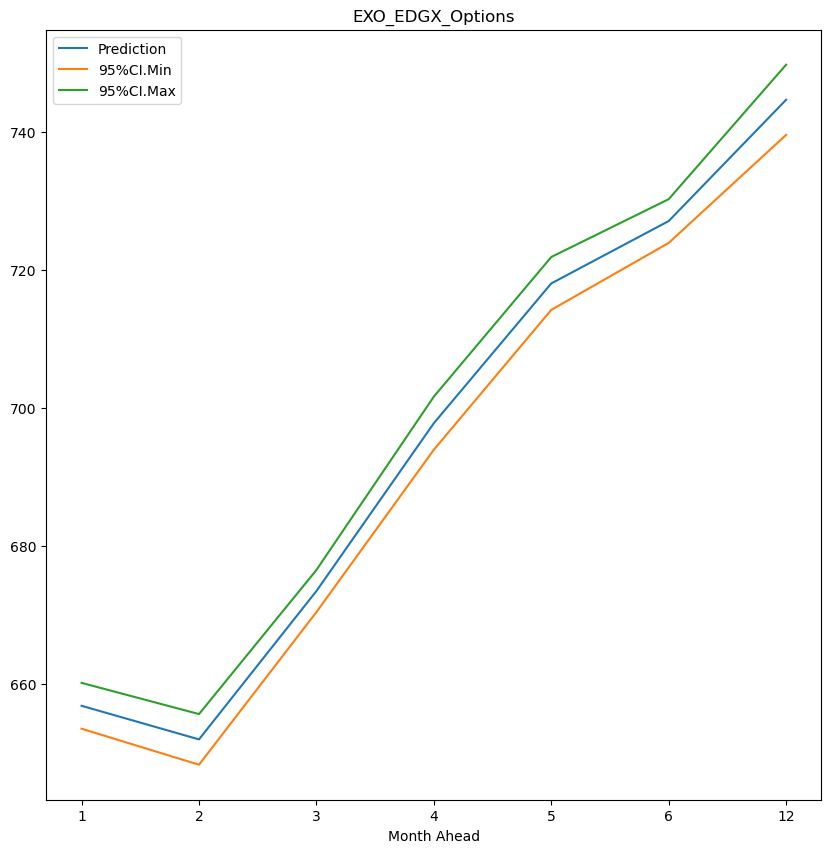

In [10]:
#Concatenate all dataframes by identical columns

df=pd.concat([outcome1, outcome2,outcome3,outcome4,outcome5,outcome6,outcome12])
# df=pd.concat([outcome6,outcome12])

insert_index = 0
insert_colname = 'Asset'
insert_values = ['Options','Options','Options','Options','Options','Options','Options'] # this can be a numpy array too
# insert_values = ['Options','Options'] # this can be a numpy array too
df.insert(loc=insert_index, column=insert_colname, value=insert_values)


insert_index = 1
insert_colname = 'Product'
insert_values = [sheet,sheet,sheet,sheet,sheet,sheet,sheet] # this can be a numpy array too
# insert_values = [sheet,sheet] # this can be a numpy array too
df.insert(loc=insert_index, column=insert_colname, value=insert_values)

insert_index = 2
insert_colname = 'Month Ahead'
insert_values = ['1','2','3','4','5','6','12'] # this can be a numpy array too
# insert_values = ['6','12'] # this can be a numpy array too
df.insert(loc=insert_index, column=insert_colname, value=insert_values)

globals()[sheet] = df

import matplotlib.pyplot as mp
df.plot(title=sheet,x='Month Ahead',y=["Prediction","95%CI.Min","95%CI.Max"],kind="line",figsize=(10,10))
mp.show()

In [11]:
globals()

{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['',
  "# sheet='C1'\n# sheet='C2'\n# sheet='BYX'\n# sheet='BZX'\n# sheet='EDGA'\n# sheet='EDGX_Equities'\nsheet='EXO_EDGX_Options'\n# sheet='OPT_BZX_BATS'\n# sheet='CFE'",
  "from math import sqrt\nfrom numpy import concatenate\nfrom matplotlib import pyplot\nimport pandas as pd\nfrom pandas import read_csv\nfrom pandas import DataFrame\nfrom pandas import concat\nfrom sklearn.preprocessing import MinMaxScaler\nfrom sklearn.preprocessing import LabelEncoder\nfrom sklearn.metrics import mean_squared_error\nfrom keras.models import Sequential\nfrom keras.layers import Dense\nfrom keras.layers import LSTM\n\n\nimport io\nimport datetime\n\n# sheet='C1'\n# sheet='C2'\n# sheet='BYX'\n# sheet='BZX'\n# sheet='EDGA'\n# sheet=